In [306]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics

# For debug purposes only. To be removed.
import time as tiime

# Process trajectory simulations:

## Brownian motion
The function `BM_path` takes in a list `time_points` of `float` values, and returns a dictionary with this list as its keys and values of a simulated standard Brownian motion at each point in `time_points`.

In [2]:
# time_points is the list of points in which we simulate the process at
def BM_path(time_points):
    trajectory = [0]
    for t in range(1, len(time_points)):
        realization = trajectory[-1]+np.sqrt(time_points[t]-time_points[t-1])*np.random.normal()
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

#### Example:

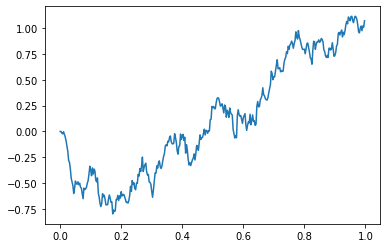

In [3]:
BM1 = BM_path([i/360 for i in range(360)])
plt.plot(list(BM1.keys()), list(BM1.values()))

## Poisson process
The function `poisson_path` takes two parameters: ... TO-WRITE 

In [4]:
def poisson_path(intensity, time_points):
    i = intensity*(time_points[1]-time_points[0])
    trajectory = [0]
    for t in time_points:
        trajectory.append(trajectory[-1]+np.random.poisson(i))
    return dict(zip(time_points, trajectory))

In [5]:
def poisson_path_2(intensity, time_points):
    #parameters & discretization
    beta = 1/intensity
    
    #generating trajectory for s process
    s_trajectory = [0]
    for i in range(len(time_points)):
        realization = s_trajectory[-1]-np.log(np.random.uniform())/intensity
        s_trajectory.append(realization)
    
    #poisson trajectory
    trajectory = [0]
    for t in time_points:
        realization = max([k for k in range(0,len(time_points)+1) if s_trajectory[k] <= t])
        trajectory.append(realization)
    
    return dict(zip(time_points, trajectory))

#### Example:

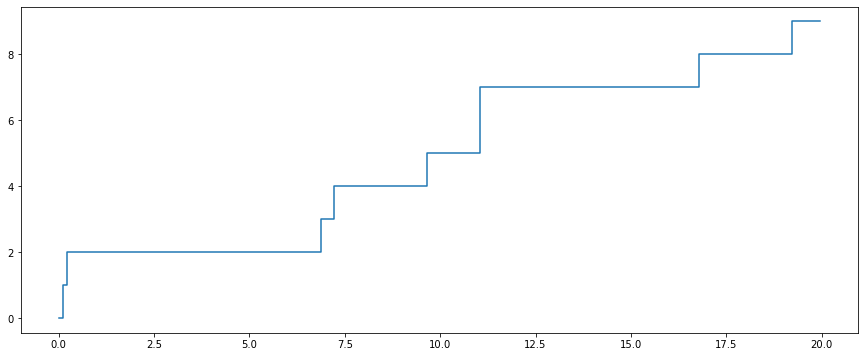

In [6]:
p = poisson_path(0.5, [i/360*20 for i in range(360)])
plt.figure(figsize = (15,6))
plt.step(list(p.keys()),list(p.values()))

## Meixner process

In [107]:
# this is defined so that we do not repeatedly compute the integrals inside the meixner trajectory function
def meix_optimization(k, alpha, a, b, d):
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(k,alpha)
    partition = left_part + right_part
    #left_part.insert(0, -1)
    #right_part.append(1)
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    
    return partition, lambdas, c, gamma_, sigma_

indicator = lambda cond : 1 if cond else 0

In [122]:
def meixner_trajectory(time_points, a, b, d, o_params):
    partition, lambdas, c, gamma_, sigma_ = o_params
    """
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(100,0.6)
    left_part.insert(0, -1)
    right_part.append(1)
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    """
    
    # the actual trajectory of the meixner process starts here
    bm = BM_path(time_points)
    N = [poisson_path(l, time_points) for l in lambdas]
    
    trajectory = []
    for t in time_points:
        s = [c[j]*( N[j][t] - lambdas[j]*t*indicator(np.abs(c[j]) < 1) ) for j in range(len(c))]
        #s = [c[j]*( N[j][t] - lambdas[j]*t) for j in range(200)]
        realization = gamma_*t + sigma_*bm[t] + sum(s)
        #realization = sigma_*bm[t] + sum(s)
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

#### Example:

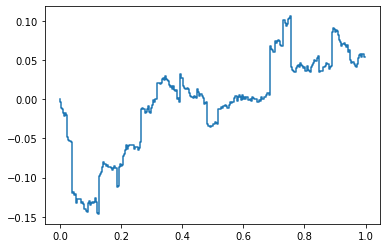

In [138]:
optimization_params = meix_optimization(100, 1, 0.1231, -0.5875, 3.3588)
meix = meixner_trajectory([i/300 for i in range(300)], 0.1231, -0.5875, 3.3588, optimization_params)
plt.step(list(meix.keys()), list(meix.values()))

## Cox-Ingersoll-Ross process

In [9]:
def cir(T, time_points, kappa, eta, lamb, y0):
    increment = T/time_points
    y = np.zeros(time_points)
    y[0] = y0
    for i in range(time_points-1):
        y[i+1] = np.abs(y[i] + kappa * (eta - y[i]) * increment + lamb * math.sqrt(y[i])*math.sqrt(increment) * np.random.normal(0,1))
    return y

### Integrated Cox-Ingersoll-Ross process

In [10]:
def int_cir(T, time_points, kappa, eta, lamb, y0):
    Y = np.zeros(time_points+1)
    Y[0] = y0
    fixed_cir = cir(T, time_points, kappa, eta, lamb, y0)
    for i in range(len(cir(T, time_points, kappa, eta, lamb, y0))):
        Y[i+1] = Y[i] + fixed_cir[i]
    return dict(zip([T/time_points * i for i in range(time_points+1)], Y/time_points))

## The subordinated Meixner process

In [147]:
def subordinated_meixner(T, time_points, kappa, eta, lamb, y0, a, b, d, o_params):
    path = int_cir(T, time_points, kappa, eta, lamb, y0)
    det_time = list(path.keys())
    t_points = list(path.values())
    sub_meix = list(meixner_trajectory(t_points, a, b, d, o_params).values())
    return dict(zip(det_time, sub_meix))

#### Example:

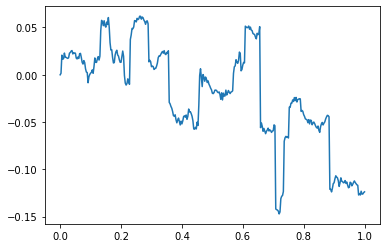

In [148]:
sub_o_params = meix_optimization(100, 1, 0.1231, -0.5875, 3.3588)
s = subordinated_meixner(1, 360, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, sub_o_params)
plt.plot(list(s.keys()), list(s.values()))

## Characteristic functions

In [13]:
r = 1.9/100
q = 1.2/100
coth = lambda x : np.cosh(x)/np.sinh(x) if x != 0 else 0
def phi_cir(t, T, K, kappa, eta, lamb, y0, a, b, d, u):
    gamma = np.sqrt(complex(kappa**2, -2*lamb**2*u))
    return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))
    
def psi_X(t, T, K, kappa, eta, lamb, y0, a, b, d, u):
    return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))

def phi(t, T, K, kappa, eta, lamb, y0, a, b, d, u):
    S0 = 1124.47
    return np.exp(complex(0, u*((r-q)*t)))*(phi_cir(t, T, K, kappa, eta, lamb, y0, a, b, d, complex(0,-psi_X(t, T, K, kappa, eta, lamb, y0, a, b, d, u))))/(phi_cir(t, T, K, kappa, eta, lamb, y0, a, b, d, complex(0,-psi_X(t, T, K, kappa, eta, lamb, y0, a, b, d,complex(0,-1)))))**complex(0,u)
               #return np.exp(complex(0, u*((r-q)*t))*(phi_cir(t, T, K, kappa, eta, lamb, y0, a, b, d, complex(0,-psi_X(t, T, K, kappa, eta, lamb, y0, a, b, d, u))))/(phi_cir(t, T, K, kappa, eta, lamb, y0, a, b, d, complex(0,-psi_X(t, T, K, kappa, eta, lamb, y0, a, b, d,complex(0,-1)))))**complex(0,u))

exp_value = phi(337/365, 337/365, 1175, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, complex(0,-1))
e = np.real(exp_value)

## $S_t$ process

In [139]:
def meixner_martingale(S0, r, q, T, a, b, d, o_params):
    m_new = r-q-2*d*(np.log(np.cos(b/2))-np.log(np.cos((a+b)/2)))
    #S0 = 1124.47
    path = meixner_trajectory([T*i/200 for i in range(200)], a, b, d, o_params)
    t = np.array(list(path.keys()))
    x_t = np.array(list(path.values()))
    return dict(zip(t,S0*np.exp(m_new*t+x_t)))

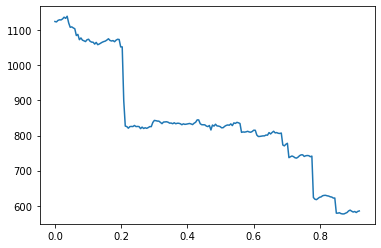

In [140]:
path = meixner_martingale(1124.47, 1.9/100, 1.2/100, 337/365, 0.3977, -1.4940, 0.3462, optimization_params)
plt.plot(path.keys(), path.values())

# Monte-Carlo Simulations

## Meixner without subordinator

In [17]:
def payoff_eur_call(ST, K):
    return max(ST-K,0)

In [317]:
def mc_ec_meixner(S0, r, q, T, K, a, b, d, sims, o_params):
    t=[]
    for i in range(sims):
        #t.append(payoff(1.9/100, 1.2/100, 337/365, 0.3977, -1.4940, 0.3462, 1150))
        final_value = list(meixner_martingale(S0, r, q, T, a, b, d, o_params).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [311]:
def mc_ec_sub_meixner(S0, r, q, T, K, kappa, eta, lamb, y0, a, b, d, sims, o_params):
    t=[]
    # meixner_sub_martingale(S0, T, r, q, time_points, kappa, eta, lamb, y0, a, b, d, o_params):
    for i in range(sims):
        #t.append(payoff(1.9/100, 1.2/100, 337/365, 0.3977, -1.4940, 0.3462, 1150))
        final_value = list(meixner_sub_martingale(S0, T, r, q, 250, kappa, eta, lamb, y0, a, b, d, o_params).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [326]:
s1 = tiime.time()
resl1 = mc_ec_meixner(1124.47, 1.9/100, 1.2/100, 337/365, 1150, 0.3977, -1.4940, 0.3462, 1000, optimization_params)
print(tiime.time() - s1)

84.944176197052


In [330]:
s1 = tiime.time()
resl2 = mc_ec_sub_meixner(1124.47, 1.9/100, 1.2/100, 337/365, 1150, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, 1000, sub_o_params)
print(tiime.time() - s1)

120.15751719474792


In [331]:
resl2

18.10688146402215

In [125]:
optimization_params = meix_optimization(100, 1, 0.1231, -0.5875, 3.3588)

In [133]:
%%time
# this is slow. Run at your own peril

K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]

mc_predictions = []
for k in K_list:
    mc_predictions.append(mc_ec_meixner(1124.47, 1.9/100, 1.2/100, 337/365, k, 0.3977, -1.4940, 0.3462, 1000, optimization_params))
the_reveal = list(zip(mc_predictions, prices_list))

CPU times: user 15min 37s, sys: 2.01 s, total: 15min 39s
Wall time: 24min 47s


In [76]:
l_results = list(the_reveal)

In [136]:
the_reveal

[(127.73670916073377, 146.5),
 (84.22706492132176, 96.2),
 (73.53085429952027, 81.7),
 (61.76231943259176, 68.3),
 (50.41618094551783, 56.6),
 (36.72118852210744, 46.1),
 (28.380714079491725, 36.9),
 (26.17834872022791, 29.3),
 (21.461592607188894, 22.5),
 (17.849096104838548, 17.2),
 (12.850151782597148, 12.8)]

In [134]:
arpe = 1/len(the_reveal)*sum([abs(market - model)/market for model, market in the_reveal])

In [135]:
print(arpe*100)

10.783352758140072


In [79]:
arpe

0.06448215070467002

In [80]:
for model, market in l_results:
    print(model, market)

148.1517266468398 146.5
94.4916609091996 96.2
88.56576111887256 81.7
65.70287348670608 68.3
57.65347374428555 56.6
47.61300220462265 46.1
40.196771737173144 36.9
32.045879152969505 29.3
22.76805364713765 22.5
20.486920996672954 17.2
14.345008136264642 12.8


## Meixner with subordinator

In [165]:
def meixner_sub_martingale(S0, T, r, q, time_points, kappa, eta, lamb, y0, a, b, d, o_params):
    path = subordinated_meixner(T, time_points, kappa, eta, lamb, y0, a, b, d, o_params)
    t = np.array(list(path.keys()))
    x_yt = np.array(list(path.values()))
    risk_neutral = S0*np.exp((r-q)*t)/e * np.exp(x_yt)
    return dict(zip(t, list(risk_neutral)))

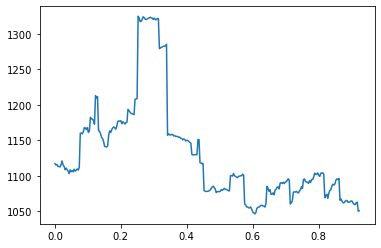

In [302]:
sub_path = meixner_sub_martingale(1124.47, 337/365, 1.9/100, 1.2/100, 300, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, sub_o_params) 
plt.plot(sub_path.keys(), sub_path.values())

## Trajectory plots

### Subordinated Meixner (with Schoutens' parameters)

Text(0.5, 1.0, 'Meixner (with subordinator)')

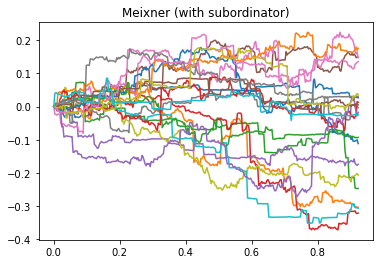

In [177]:
for i in range(20):
    #subordinated_meixner(T, time_points, kappa, eta, lamb, y0, a, b, d, o_params)
    path = subordinated_meixner(337/365, 300, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, sub_o_params) 
    plt.plot(path.keys(), path.values())
plt.title("Meixner (with subordinator)")

### Meixner (with subordinator) with $\kappa = 1$, $\eta = 2$, $\lambda =3$, $a = 1$ , $b=2$, $d=3$

Text(0.5, 1.0, 'Meixner (with subordinator)')

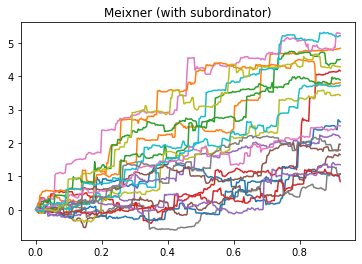

In [183]:
sub_o_params2 =  meix_optimization(100, 1, 1, 2, 3)
for i in range(20):
    #subordinated_meixner(T, time_points, kappa, eta, lamb, y0, a, b, d, o_params)
    path = subordinated_meixner(337/365, 300, 1, 2, 3, 1, 1, 2, 3, sub_o_params2) 
    plt.plot(path.keys(), path.values())
plt.title("Meixner (with subordinator)")

### Meixner (without subordinator) with Schoutens' parameters

Text(0.5, 1.0, 'Meixner (without subordinator)')

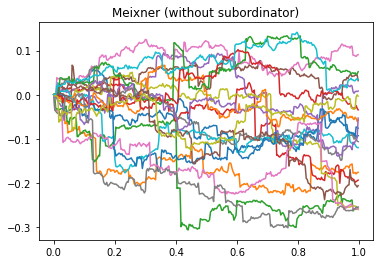

In [179]:
for i in range(20):
    #meixner_trajectory(time_points, a, b, d, o_params):
    path = meixner_trajectory([i/300 for i in range(300)], 0.3977, -1.4940, 0.3462, optimization_params)
    plt.plot(path.keys(), path.values())
plt.title("Meixner (without subordinator)")

### Meixner (without subordinator) with $a = 1$ , $b=2$, $d=3$

Text(0.5, 1.0, 'Meixner (without subordinator)')

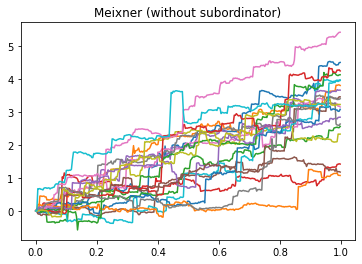

In [184]:
for i in range(20):
    #meixner_trajectory(time_points, a, b, d, o_params):
    path = meixner_trajectory([i/300 for i in range(300)], 1, 2, 3, sub_o_params2 )
    plt.plot(path.keys(), path.values())
plt.title("Meixner (without subordinator)")

## Two cir plots

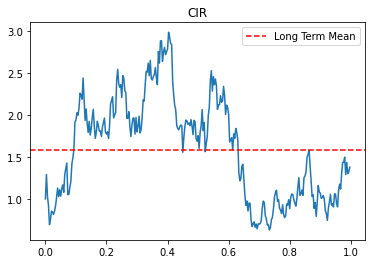

In [278]:
cir1 = cir(1, 300, 0.5705, 1.5863, 1.9592, 1)
time = [t/300 for t in range(300)]
plt.plot(time,cir1)
plt.title('CIR')
plt.axhline(1.5863, linestyle='--', color = 'r', label = 'Long Term Mean')
plt.legend()

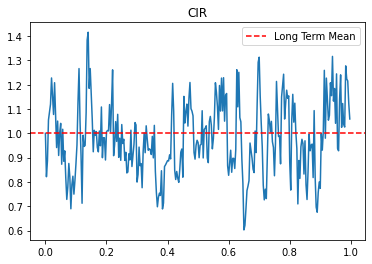

In [275]:
cir1 = cir(1, 300, 100, 1, 2, 1)
time = [t/300 for t in range(300)]
plt.plot(time,cir1)
plt.title('CIR')
plt.axhline(1, linestyle='--', color = 'r', label = 'Long Term Mean')
plt.legend()

## Intcir vs. linear time

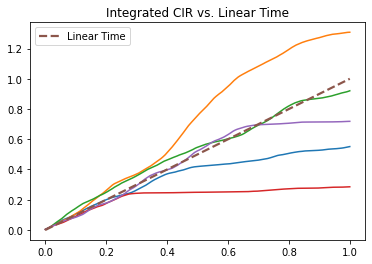

In [242]:
for i in range(5):
    intcir_path = int_cir(1, 300, 0.5705, 1.5863, 1.9592, 1)
    intcir_t = intcir_path.keys()
    intcir_image = intcir_path.values()
    plt.plot(intcir_t, intcir_image)

t = [0,1]
plt.plot(t, linestyle = '--', linewidth = 2.2, label = 'Linear Time')
plt.legend()
plt.title("Integrated CIR vs. Linear Time")
plt.savefig('intcirvsltime')

# Exotic option pricing

In [282]:
def payoff_DIBC(trajectory, T, H, K):
    vals = trajectory
    min_realization = min(vals)
    ST = vals[-1]
    return payoff_eur_call(ST, K)*(min_realization <= H)

In [294]:
def mc_DIBC_sub_meixner(S0, r, q, T, H, K, sims, o_params):
    payoffs = []
    for i in range(sims):
        path = meixner_sub_martingale(S0, T, r, q, 250, 0.5705, 1.5863, 1.9592, 1, 0.1231, -0.5875, 3.3588, o_params) 
        payoffs.append(payoff_DIBC(list(path.values()), T, H, K))
    return np.exp(-r*T)*np.mean(payoffs)

In [297]:
#1.9/100, 1.2/100, 337/365, 1150, 0.3977, -1.4940, 0.3462, 1000
barrier_mc = mc_DIBC_sub_meixner(1124.47,1.9/100, 1.2/100, 1, 1124.47*0.95, 1124.47, 1000, sub_o_params)

In [298]:
barrier_mc

7.335601551441637

In [290]:
payoff_DIBC([1000, 1025, 980, 1100], 1, 975, 1050)

0

In [1]:
barrier_mc = mc_DIBC_sub_meixner(1, 1124.47*0.95, 1124.47, 2000)

NameError: name 'mc_DIBC_sub_meixner' is not defined